<a href="https://colab.research.google.com/github/JotaBlanco/TheValley/blob/main/Arboles/Workshop/Workshop_Modelizacion_I_RESUELTO_Jimena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

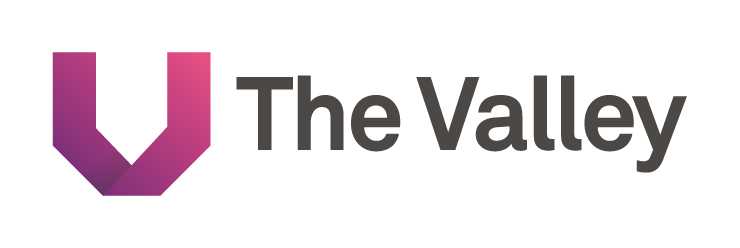</img>

# Workshop de modelización: Modelos Supervisados

Una empresa de inversión en activos inmobiliarios, busca la creación de un algoritmo que estime el precio de una vivienda. El objetivo de este sistema es doble:

1. Poder tasar casas de manera automática
2. Poder encontrar activos que estén bien de precio

Para ello os unís al uniros al equipo de Data Science de un fondo de inversión y os detallan los diferentes pasos para aproximar el problema:



### 1) Exploratory Data Analysis

1.   Comprobar que el Dataset está balanceado
2.   Visualizaciones del conjunto de datos con la librería seaborn
3.   Detección de outliers

### 2) Feature Engineering (Ingeniería de variables)

1. Manipulación de las variables existentes
2. Creación de nuevas variables para el modelo
3. (Extra) Utilización de target encoding
4. (Extra) ¿Qué datos externos utilizarías?

### 3) Modelado

1. Utilización de diferentes modelos dados en clase: k-nn, Random Forest, Regresión Lineal, XGBoost
2. Elección de una métrica de evaluación
3. Split entre train y test de los datos


### 4) Overfitting (Extra)

1. RMSE más bajo que puede obtener para el conjunto de entrenamiento (MAL ENTRENADO)
2. Evalua gráficamente tu overfitting
3. (Extra) Analiza la descomposición entre sesgo y varianza

### 5) Evaluación de predicciones

1. Evalua el rendimiento de los diferentes modelos
2. Dadas las predicciones de tus modelos, explorar donde funciona mejor y peor
3. Selecciona un modelo
4. Conclusiones

### 6) Encontrar Chollos (Extra)

1. ¿Cómo orientarías la búsqueda de chollos en el dataset?
2. ¿Cómo varía la modelización al buscar oportunidades inmobiliarias?



### 0) Cargamos nuestra base de datos

La información está en el siguiente enlace:

url = 'https://raw.githubusercontent.com/JimenaAreta/thevalley-MDS/jimena/datasets/sample-flats-madrid-synthetic-coords-pelayo.csv'

Contiene las siguientes columnas:

 - `CODE`, código de la referencia
 - `LOCATIONNAME`, nombre de la localización
 - `PRICE`, precio de venta en €
 - `AREA`, metros cuadrados ($m^2$)
 - `ROOMNUMBER`, número de habitaciones
 - `BATHNUMBER`, número de baños
 - `STATUS`, estado del piso
 - `STUDIO`, es un estudio
 - `ISPENTHOUSE`, es una casa
 - `DUPLEX`, es un duplex
 - `SWIMMINGPOOL`, tiene piscina
 - `ELEVATOR`, tiene ascensor
 - `X` Longitud en UTM
 - `Y` Latitud en UTM



In [ ]:
!pip install utm

In [ ]:
!pip install category_encoders

In [ ]:
# Cargamos las librerías que consideremos necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import utm
from sklearn.model_selection import StratifiedKFold
# Importamos scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Importamos  train_test_split function
from sklearn.model_selection import train_test_split
# Tranformación de variables
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import branca.colormap as cm

In [ ]:
# Cargamos la información del dataset y visualizamos las primeras filas
# Cargamos la información del dataset y visualizamos las primeras filas
df_flats = pd.read_csv('https://raw.githubusercontent.com/JimenaAreta/thevalley-MDS/refs/heads/jimena/datasets/sample-flats-madrid-synthetic-coords.csv', delimiter=',')
df_flats.head()

,CODE,LOCATIONNAME,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STATUS,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y
0,6606863734075793541,El Viso,1869000,290,4,3,Second hand / Good state,0,1,1,0,1,441543,4478087
1,9223372036854775807,Adelfas,317000,75,2,1,Second hand / Good state,0,0,0,0,1,442956,4472317
2,9223372036854775807,Rosas,292000,90,2,2,Second hand / Good state,0,0,0,1,1,448837,4475183
3,6074027706670131934,Palomeras Bajas,95000,75,3,1,Second hand / Good state,0,0,0,0,0,444520,4470756
4,9223372036854775807,San Diego,86000,90,0,1,Second hand / Needs reformation,0,0,0,0,0,443178,4470744



### 1) Exploratory Data Analysis

1.  Análisis estadístico, correlaciones, comprobar si el dataset está desbalanceado ...
2.   Visualizaciones del conjunto de datos con la librería seaborn
3.   Deteccción de outliers
4.   Mapa interactivo leaflet (Extra)


In [ ]:
# Análisis estadístico básico
df_flats.describe(include='all')

,CODE,LOCATIONNAME,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STATUS,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y
count,2.675500e+04,26755,2.675500e+04,26755.000000,26755.000000,26755.000000,26755,26755.000000,26755.000000,26755.000000,26755.000000,26755.000000,26755.000000,2.675500e+04
unique,NaN,136,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Lavapiés-Embajadores,NaN,NaN,NaN,NaN,Second hand / Good state,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,756,NaN,NaN,NaN,NaN,19787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.945068e+18,NaN,4.657609e+05,111.064100,2.660774,1.649150,NaN,0.026462,0.059951,0.028256,0.133134,0.689553,441732.160531,4.474792e+06
std,2.951807e+18,NaN,8.058151e+05,107.592568,1.280196,0.949687,NaN,0.160509,0.237401,0.165708,0.339726,0.462685,3281.459479,3.741864e+03
min,3.501304e+14,NaN,0.000000e+00,10.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,429350.000000,4.464416e+06
25%,4.698302e+18,NaN,1.600000e+05,65.000000,2.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,439887.000000,4.472003e+06
50%,9.223372e+18,NaN,2.710000e+05,85.000000,3.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,441263.000000,4.475090e+06
75%,9.223372e+18,NaN,5.080000e+05,125.000000,3.000000,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,443504.500000,4.477220e+06


Se observa que hay pisos con precio 0, sería recomendable eliminarlos del análisis ya que seguramente sean errores

In [ ]:
df_flats = df_flats[df_flats['PRICE'] != 0]

Me voy a quedar con viviendas que valen al menos 100000 euros

In [ ]:
df_flats = df_flats[(df_flats["PRICE"]>100000)]

In [ ]:
# Distribución de los pisos por barrios
df_flats['LOCATIONNAME'].value_counts(normalize=True)

,proportion
LOCATIONNAME,
Lavapiés-Embajadores,0.029179
Goya,0.023820
Malasaña-Universidad,0.022708
Recoletos,0.022153
Pueblo Nuevo,0.018262
...,...
Aeropuerto,0.000556
Encinar de los Reyes,0.000437
El Plantío,0.000318


Se observa que los datos por barrio no están balanceados (será interesante cuando hagamos el train test split tenerlo en cuenta)

In [ ]:
# Vemos las variables que tenemos y su tipo
df_flats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25189 entries, 0 to 26754
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CODE          25189 non-null  int64 
 1   LOCATIONNAME  25189 non-null  object
 2   PRICE         25189 non-null  int64 
 3   AREA          25189 non-null  int64 
 4   ROOMNUMBER    25189 non-null  int64 
 5   BATHNUMBER    25189 non-null  int64 
 6   STATUS        25189 non-null  object
 7   STUDIO        25189 non-null  int64 
 8   ISPENTHOUSE   25189 non-null  int64 
 9   DUPLEX        25189 non-null  int64 
 10  SWIMMINGPOOL  25189 non-null  int64 
 11  ELEVATOR      25189 non-null  int64 
 12  X             25189 non-null  int64 
 13  Y             25189 non-null  int64 
dtypes: int64(12), object(2)
memory usage: 2.9+ MB


<Axes: >

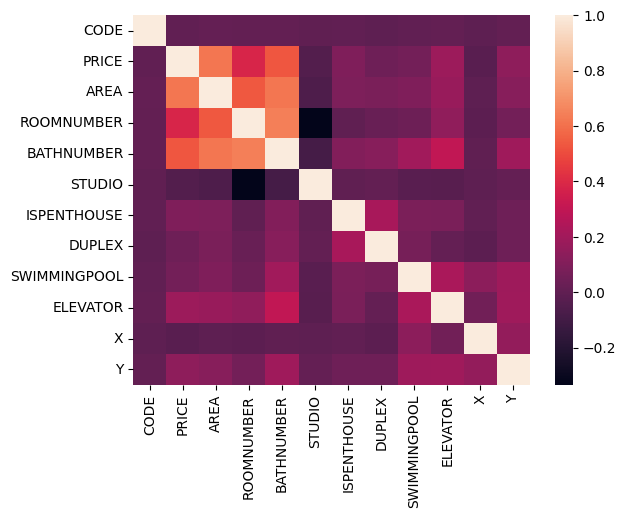

In [ ]:
# Gráfico de correlaciones
sns.heatmap(df_flats.select_dtypes(int).corr())

<Axes: xlabel='PRICE', ylabel='Density'>

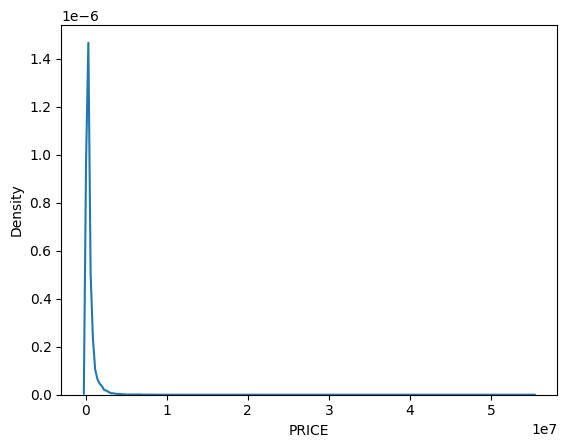

In [ ]:
# Distribución del precio
sns.kdeplot(df_flats, x= 'PRICE')

Para poder trabajar mejor la variable objetivo sería interesante realizar una transformación a la distribución para asemejarla a una distribución normal (por ejemplo, una transformación logarítmica) -> para modelos de árboles no es necesario pero para modelos lineales sí es recomendable

<Axes: xlabel='PRICE'>

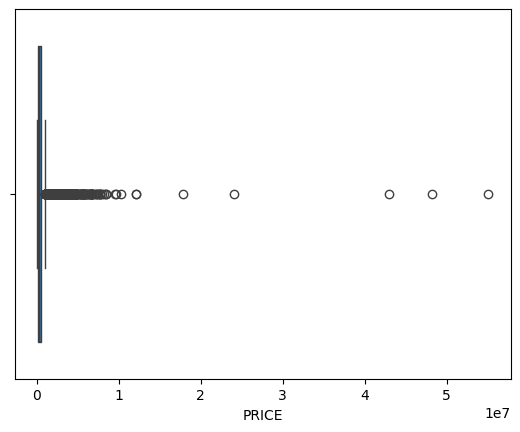

In [ ]:
# Representación en el boxplot para visualizar outliers
sns.boxplot(df_flats, x = 'PRICE')

In [ ]:
# la distribución si aplicamos una transformación logarítmica quedaría de la siguiente forma
df_flats['PRICE_LOG'] = np.log(df_flats['PRICE'])

<Axes: xlabel='PRICE_LOG', ylabel='Density'>

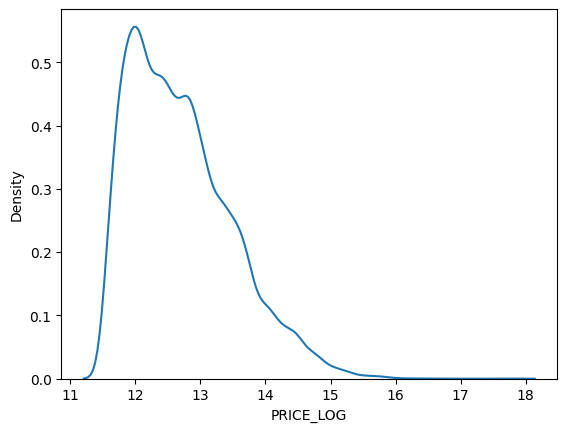

In [ ]:
# Distribución del precio
sns.kdeplot(df_flats, x= 'PRICE_LOG')

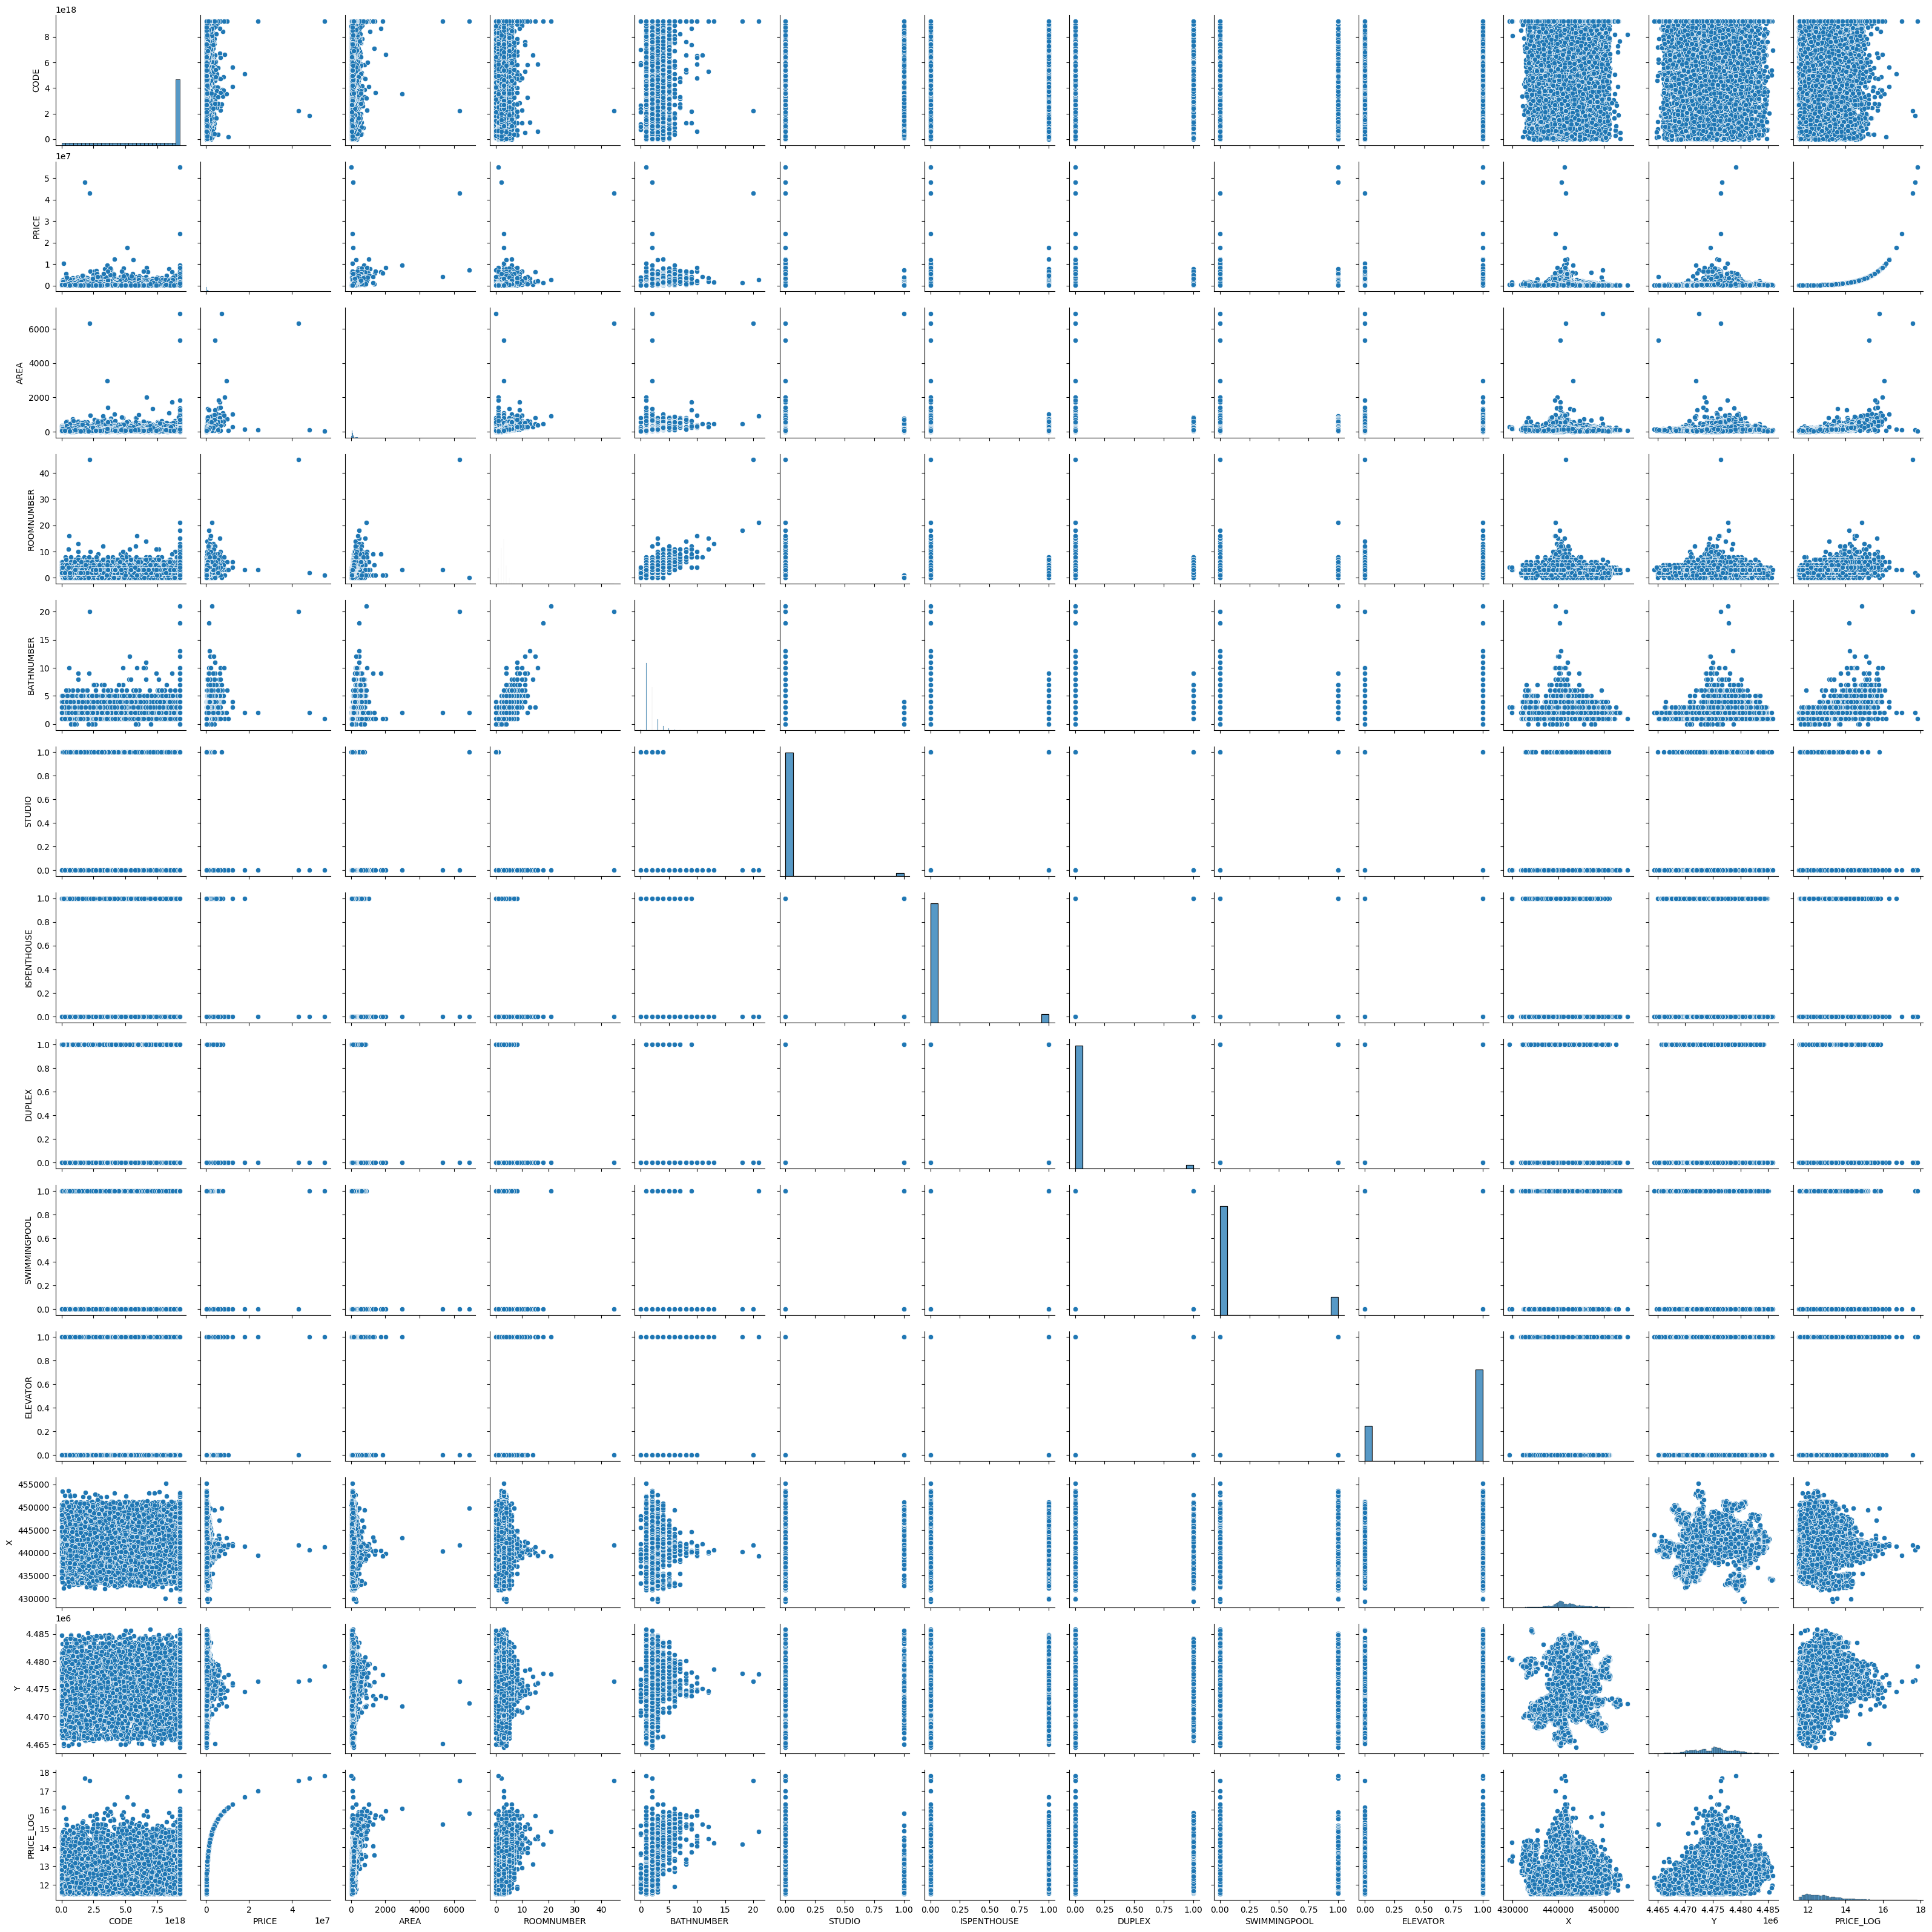

In [ ]:
# Vemos relación entre variables
# Número de habitaciones y precio
sns.pairplot(df_flats)

In [ ]:
# Función para convertir una fila de coordenadas UTM a latitud y longitud
def utm_to_latlon(row):
    lat, lon = utm.to_latlon(row['X'] , row['Y'], 30, 'T')
    return pd.Series({'latitude': lat, 'longitude': lon})

# Aplicar la conversión a cada fila del DataFrame (vamos a filtrar porque son muchos puntos)
df_flats[['latitude', 'longitude']] = df_flats.apply(utm_to_latlon, axis=1)

df_flats_filt = df_flats.sample(500)


import folium
# The Valley: Lat / Long 40.43286340023072, -3.705797432139346
m = folium.Map(location=[40.43286340023072, -3.705797432139346], zoom_start=20)
folium.Marker([40.43286340023072, -3.705797432139346],popup='The Valley',tooltip='MDS+').add_to(m)

# Añadir marcadores para cada fila del DataFrame
for _, row in df_flats_filt.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Coordenadas: ({row['latitude']}, {row['longitude']})"
    ).add_to(m)

m

### 2) Feature Engineering (Ingeniería de variables)

1. Manipulación de las variables existentes - Aplicación de técnicas de transformación de variables categóricas
2. Creación de nuevas variables para el modelo
3. (Extra) ¿Qué datos externos utilizarías?


In [ ]:
# Separamos las variables numéricas de las categóricas
numeric_cols = df_flats.select_dtypes([int,float]).columns
cat_cols = df_flats.select_dtypes(object).columns

In [ ]:
# Creamos una variable que sea el precio medio por metro cuadrado para cada barrio
df_flats['price_per_m2'] = df_flats['PRICE'] / df_flats['AREA']

In [ ]:
# Calculamos el precio medio por localización y renombramos la columna
mean_price = df_flats.groupby('LOCATIONNAME')['price_per_m2'].mean()
# ELIMINAMOS la variable de precio por m2 porque está correlada directamente con el target
df_flats = df_flats.drop('price_per_m2', axis = 1)
# Unimos por barrio al dataframe original
# Fusionar los datos con el dataframe original
df_flats = pd.merge(df_flats, mean_price, on='LOCATIONNAME', how='left')

In [ ]:
df_flats

,CODE,LOCATIONNAME,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STATUS,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y,PRICE_LOG,latitude,longitude,price_per_m2
0,6606863734075793541,El Viso,1869000,290,4,3,Second hand / Good state,0,1,1,0,1,441543,4478087,14.440914,40.451388,-3.689389,6457.190978
1,9223372036854775807,Adelfas,317000,75,2,1,Second hand / Good state,0,0,0,0,1,442956,4472317,12.666657,40.399507,-3.672209,4016.997756
2,9223372036854775807,Rosas,292000,90,2,2,Second hand / Good state,0,0,0,1,1,448837,4475183,12.584509,40.425708,-3.603142,3079.062715
3,9223372036854775807,Casa de Campo,410000,105,3,2,Second hand / Needs reformation,0,0,0,0,1,437560,4475863,12.923912,40.431064,-3.736139,3803.271684
4,5541191557223014225,Lavapiés-Embajadores,235000,50,1,1,Second hand / Good state,0,0,0,0,0,440205,4473206,12.367341,40.407323,-3.704708,4425.521422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25184,3580117655212979584,Goya,551000,170,5,2,Second hand / Good state,0,0,0,0,1,443102,4475175,13.219490,40.425263,-3.670744,5542.725818
25185,9223372036854775807,Trafalgar,577000,155,5,2,Second hand / Needs reformation,0,0,0,0,1,440737,4476236,13.265598,40.434656,-3.698721,5495.239535
25186,9223372036854775807,Ventilla-Almenara,304000,130,3,2,Second hand / Needs reformation,0,0,0,0,1,441152,4480360,12.624783,40.471836,-3.694211,3216.756193
25187,9223372036854775807,Castellana,1001000,155,4,2,Second hand / Good state,0,0,0,0,1,442184,4475840,13.816510,40.431191,-3.681626,7044.101950


In [ ]:
# Vamos a crear una variable que sea distancia en línea recta a la castellana
lat_castellana = 40.4381
lon_castellana = -3.6904

def distancia_entre_dos_puntos(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

df_flats["dist_a_castellana_km"] = df_flats.apply(
    lambda row: distancia_entre_dos_puntos(row["latitude"], row["longitude"], 40.4381, -3.6904),
    axis=1
)

In [ ]:
# Convertimos la variable Status con dummies
# Obtener variables dummy
dummies = pd.get_dummies(df_flats['STATUS'], prefix='status', drop_first=False, dtype=int)

# Concatenar las variables dummy al dataframe original
df_flats = pd.concat([df_flats, dummies], axis=1)

### 3) Modelado

1. Utilización de diferentes modelos dados en clase: Regresión lineal, Random Forest, XGBoost
2. Elección de una métrica de evaluación
3. Split entre train y test de los datos
4. Split estratificado por `LOCATIONNAME`

In [ ]:
# Dividir los datos en entrenamiento y prueba basado en las localizaciones
train_data = df_flats.groupby('LOCATIONNAME', group_keys=False).apply(lambda x: x.sample(frac=0.8, random_state=42))
test_data = df_flats.drop(train_data.index)

/tmp/ipython-input-400-232144433.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = df_flats.groupby('LOCATIONNAME', group_keys=False).apply(lambda x: x.sample(frac=0.8, random_state=42))


In [ ]:
train_data = train_data.set_index('CODE')
test_data = test_data.set_index('CODE')

In [ ]:
# Al igual que hicimos con el precio transformamos el area a una distribución más "normalizada"
train_data['AREA_LOG'] = np.log(train_data['AREA'])
test_data['AREA_LOG'] = np.log(test_data['AREA'])

In [ ]:
# Seleccionamos qué columnas queremos para entrenar
cols_lm = ['ROOMNUMBER', 'BATHNUMBER', 'STUDIO', 'ISPENTHOUSE', 'DUPLEX',
              'SWIMMINGPOOL', 'ELEVATOR', 'LOCATIONNAME', 'PRICE_LOG',  'AREA_LOG',
              'status_New development',
              'status_Second hand / Good state',
              'status_Second hand / Needs reformation',
              'dist_a_castellana_km']

In [ ]:
# Separamos en train y test de forma que tengamos tanto en train como en test el mismo % de barrios
X_train = train_data[cols_lm].drop('PRICE_LOG', axis = 1)
y_train = train_data['PRICE_LOG']

X_test = test_data[cols_lm].drop('PRICE_LOG', axis = 1)
y_test = test_data['PRICE_LOG']

In [ ]:
# Usando el target encoder convertimos los datos de la variable LOCATIONNAME a una variable numérica.
# Instanciar el TargetEncoder
encoder = TargetEncoder(cols=['LOCATIONNAME'])

# Ajustar y transformar en X_train (entrenamiento)
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Transformar X_test (prueba)
X_test_encoded = encoder.transform(X_test)


### 4) Overfitting (Extra)

1. RMSE más bajo que puede obtener para el conjunto de entrenamiento (MAL ENTRENADO)
2. Evalua gráficamente tu overfitting
3. (Extra) Analiza la descomposición entre sesgo y varianza



In [ ]:
# Definimos una función que nos devuelve el error de nuestro modelo en train y test y la degradación
def entrenar_modelo_y_predecir(modelo):
  # Entreno el árbol con el set de entrenamiento
  modelo = modelo.fit(X=X_train_encoded, y=y_train)
  # Uso el árbol para predecir sobre el dataset de entrenamiento
  y_pred_train = modelo.predict(X_train_encoded)
  # Uso el árbol para predecir sobre el dataset de test
  y_pred_test = modelo.predict(X_test_encoded)
  # Calidad predicción train
  rmse_train = round(metrics.root_mean_squared_error(y_train, y_pred_train), 2)
  print('RMSE en set de entrenamiento :', rmse_train)
  # Calidad predicción test
  rmse_test = round(metrics.root_mean_squared_error(y_test, y_pred_test), 2)
  print('RMSE en set de test :', rmse_test)
  # Degradación de la predicción
  print('Degradación: ' + str(round((rmse_test-rmse_train)/rmse_train*100,2)) + '%')

  return y_pred_test

In [ ]:
# Utilizamos un modelo de regresión lineal
modelo_lm = LinearRegression()
y_pred_lm = entrenar_modelo_y_predecir(modelo_lm)

RMSE en set de entrenamiento : 0.27
RMSE en set de test : 0.28
Degradación: 3.7%


El RMSE está en escala logarítmica, si queremos saber el error en la escala original tenemos que transformar las predicciones

In [ ]:
# Añadimos las predicciones del modelo lineal
test_data['pred_lm_log'] = y_pred_lm
test_data['pred_lm'] = np.exp(test_data['pred_lm_log'])

In [ ]:
rmse_test = round(metrics.root_mean_squared_error(test_data["PRICE"], test_data["pred_lm"]), 2)
print('RMSE en set de test :', rmse_test)

RMSE en set de test : 929790.2


Para los modelos de árboles no escalamos la variable target, no afecta la escala

In [ ]:
# Seleccionamos qué columnas queremos para entrenar
cols_tree = ['ROOMNUMBER', 'BATHNUMBER', 'STUDIO', 'ISPENTHOUSE', 'DUPLEX',
              'SWIMMINGPOOL', 'ELEVATOR', 'LOCATIONNAME', 'PRICE', 'AREA',
              'status_New development',
              'status_Second hand / Good state',
              'status_Second hand / Needs reformation','dist_a_castellana_km']

In [ ]:
# Separamos en train y test de forma que tengamos tanto en train como en test el mismo % de barrios
X_train = train_data[cols_tree].drop('PRICE', axis = 1)
y_train = train_data['PRICE']

X_test = test_data[cols_tree].drop('PRICE', axis = 1)
y_test = test_data['PRICE']

In [ ]:
# Usando el target encoder convertimos los datos de la variable LOCATIONNAME a una variable numérica.
# Instanciar el TargetEncoder
encoder = TargetEncoder(cols=['LOCATIONNAME'])

# Ajustar y transformar en X_train (entrenamiento)
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Transformar X_test (prueba)
X_test_encoded = encoder.transform(X_test)

In [ ]:
# Define el modelo de Random Forest
modelo_RF = RandomForestRegressor(
    n_estimators = 150,
    max_features = "sqrt",
    max_depth = 7)

# Entrena y evalúa el modelo
y_pred_RF = entrenar_modelo_y_predecir(modelo_RF)

RMSE en set de entrenamiento : 391875.47
RMSE en set de test : 914213.4
Degradación: 133.29%


In [ ]:
# Define el modelo de Random Forest
modelo_xgb = xgb.XGBRegressor(n_estimators = 5, max_depth = 3)

# Entrena y evalúa el modelo
y_pred_xgb = entrenar_modelo_y_predecir(modelo_xgb)

RMSE en set de entrenamiento : 482326.47
RMSE en set de test : 924536.31
Degradación: 91.68%


In [ ]:
# Añadimos las predicciones del rf y del xgb
test_data['pred_rf'] = y_pred_RF
test_data['pred_xgb'] = y_pred_xgb

### 5) Evaluación de predicciones

1. Evalua el rendimiento de los diferentes modelos
2. Dadas las predicciones de tus modelos, explorar donde funciona mejor y peor
3. Selecciona un modelo


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 9223372036854775807 to 7396179976084748118
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   LOCATIONNAME                            5043 non-null   object 
 1   PRICE                                   5043 non-null   int64  
 2   AREA                                    5043 non-null   int64  
 3   ROOMNUMBER                              5043 non-null   int64  
 4   BATHNUMBER                              5043 non-null   int64  
 5   STATUS                                  5043 non-null   object 
 6   STUDIO                                  5043 non-null   int64  
 7   ISPENTHOUSE                             5043 non-null   int64  
 8   DUPLEX                                  5043 non-null   int64  
 9   SWIMMINGPOOL                            5043 non-null   int64  
 10  ELEVATOR                        

In [ ]:
# Calculamos el MAPE y ordenamos
test_data['error_perc'] = np.abs((test_data['PRICE'] - test_data['pred_rf']) / test_data['PRICE']) * 100

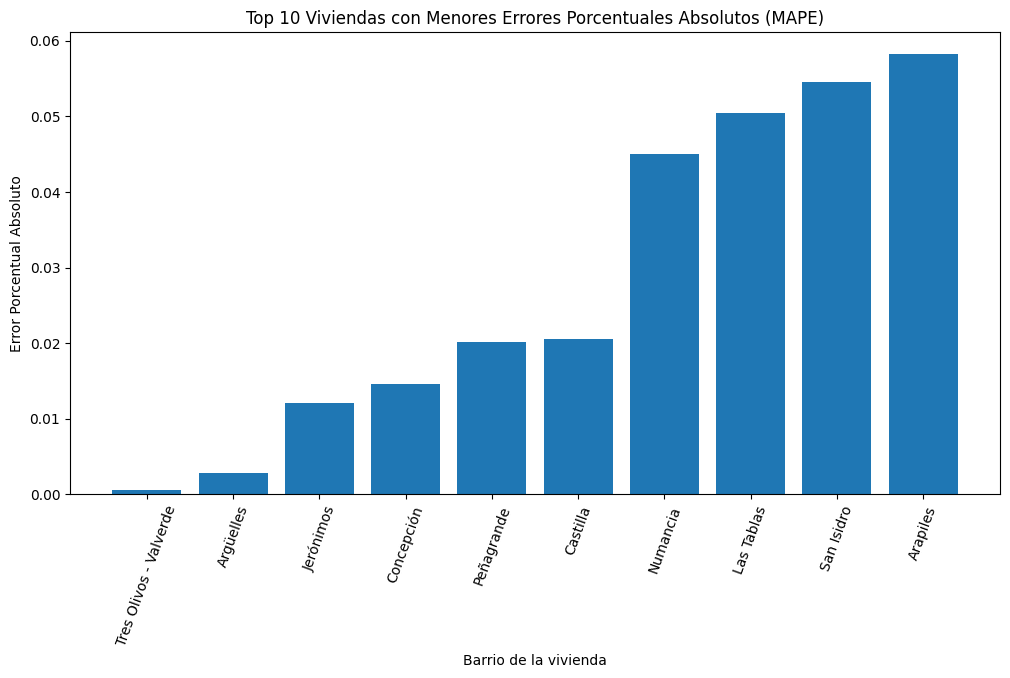

In [ ]:
# Lo pintamos en un histograma
# Seleccionar las n viviendas con mayores errores porcentuales
top_n_mape = test_data.sort_values(by='error_perc', ascending=True).head(10)

# Gráfico de barras de los errores porcentuales absolutos
plt.figure(figsize=(12, 6))
plt.bar(top_n_mape.LOCATIONNAME, top_n_mape['error_perc'])
plt.xlabel('Barrio de la vivienda')
plt.xticks(rotation = 70)
plt.ylabel('Error Porcentual Absoluto')
plt.title('Top 10 Viviendas con Menores Errores Porcentuales Absolutos (MAPE)')
plt.show()

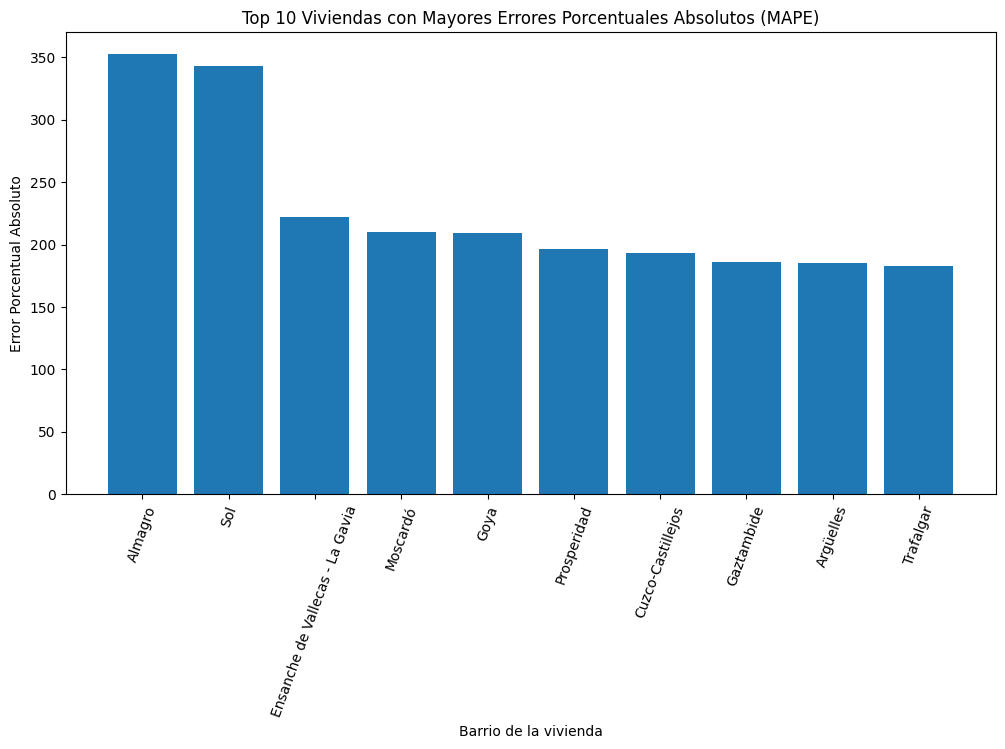

In [ ]:
# Lo pintamos en un histograma
# Seleccionar las n viviendas con mayores errores porcentuales
top_n_mape = test_data.sort_values(by='error_perc', ascending=False).head(10)

# Gráfico de barras de los errores porcentuales absolutos
plt.figure(figsize=(12, 6))
plt.bar(top_n_mape.LOCATIONNAME, top_n_mape['error_perc'])
plt.xlabel('Barrio de la vivienda')
plt.xticks(rotation = 70)
plt.ylabel('Error Porcentual Absoluto')
plt.title('Top 10 Viviendas con Mayores Errores Porcentuales Absolutos (MAPE)')
plt.show()

In [ ]:
# MAPE
test_data['error_perc'].mean()

np.float64(27.346038447604336)

In [ ]:
test_data.sort_values(by='error_perc', ascending=False).head(100)[["PRICE","pred_rf","error_perc"]]

,PRICE,pred_rf,error_perc
CODE,,,
7788010031336080779,912000,4.125115e+06,352.315228
3978440044760676753,106000,4.697343e+05,343.145582
9223372036854775807,151000,4.862576e+05,222.024883
6237307101211566963,111000,3.440378e+05,209.943931
7436825036371450635,120000,3.713680e+05,209.473359
...,...,...,...
9223372036854775807,136000,2.824060e+05,107.651437
9223372036854775807,130000,2.692917e+05,107.147472
9223372036854775807,113000,2.339287e+05,107.016542


In [ ]:
test_data.groupby("LOCATIONNAME")["error_perc"].mean().sort_values(ascending=False)

,error_perc
LOCATIONNAME,
Cuatro Vientos,107.897965
Aeropuerto,85.399740
Entrevías,68.060815
San Cristóbal,66.049366
Horcajo,58.561598
...,...
Timón,12.029052
Casco Histórico de Barajas,11.876249
Encinar de los Reyes,8.086837


In [ ]:
# Preparar los datos para el HeatMap
heat_data = [
    [row['latitude'], row['longitude'], row['error_perc']] for index, row in test_data.iterrows()
]

# Crear el HeatMap
HeatMap(heat_data).add_to(m)

# Crear la leyenda de colores usando branca.colormap
min_error = test_data['error_perc'].min()
max_error = test_data['error_perc'].max()

# Crear un colormap lineal
colormap = cm.LinearColormap(
    colors=['green', 'yellow', 'orange', 'red'],
    vmin=min_error,
    vmax=max_error,
    caption='Error Porcentual del Precio'  # Añadir un título a la leyenda
)

# Añadir la leyenda al mapa
colormap.add_to(m)

m

 99%|===================| 5002/5043 [00:57<00:00]       

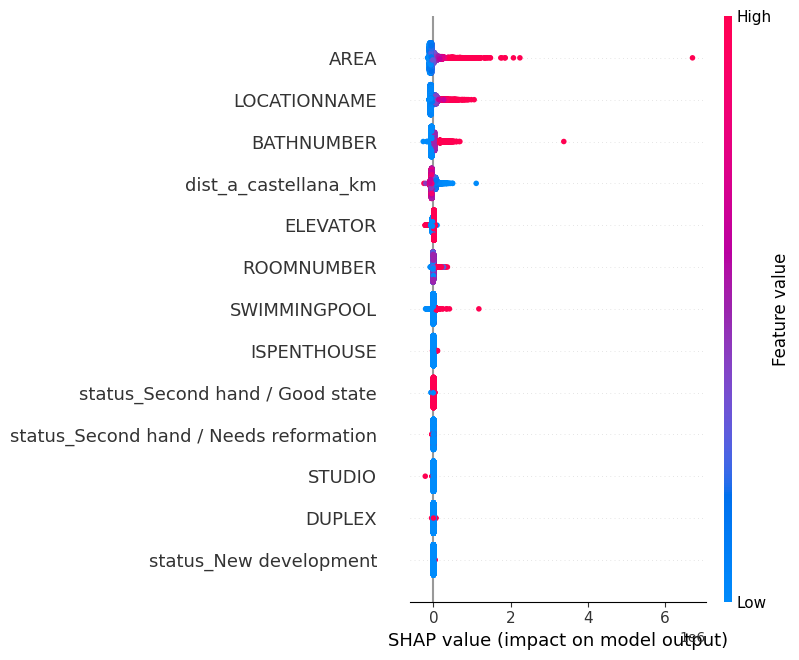

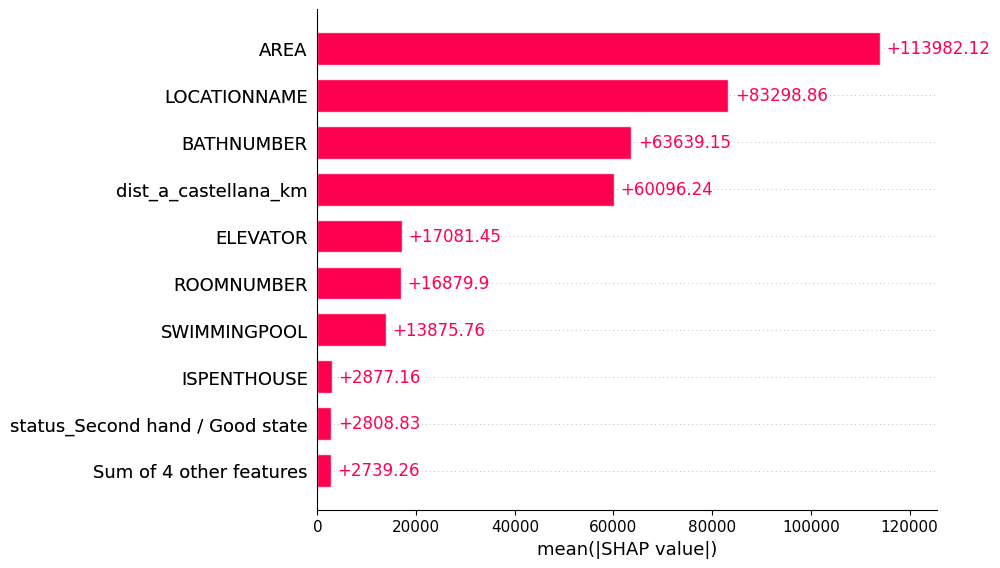

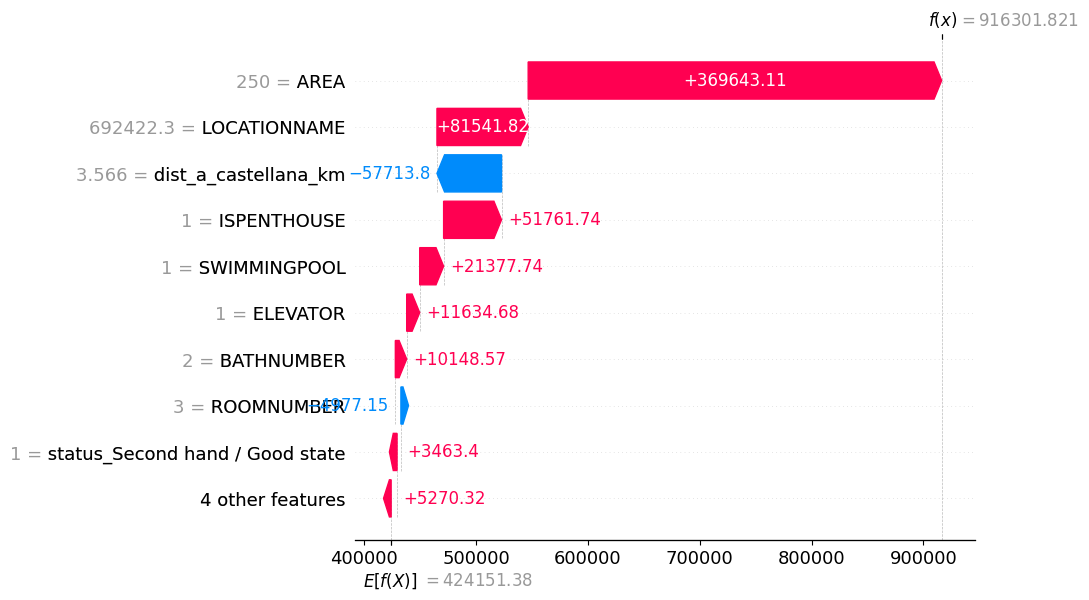

In [ ]:
# Importancia de las variables
# Calcular SHAP values
import shap
explainer = shap.Explainer(modelo_RF, X_train_encoded)
shap_values = explainer(X_test_encoded)

# Visualizaciones SHAP
shap.summary_plot(shap_values, X_test_encoded)                     # Resumen general
shap.plots.bar(shap_values)                                # Importancia global
shap.plots.waterfall(shap_values[0])                       # Explicación individual

### 6) Encontrar Chollos (Extra)

1. ¿Cómo orientarías la búsqueda de chollos en el dataset?
2. ¿Cómo varía la modelización al buscar oportunidades inmobiliarias?




1. ¿Cómo orientarías la búsqueda de chollos en el dataset?

**Análisis de Residuos:** Después de entrenar tu modelo de regresión, puedes analizar los residuos (diferencia entre las predicciones y los valores reales).

Propiedades con residuos negativos (predicción por encima del valor real) podrían ser candidatas para chollos, ya que indican que se vendieron por menos de lo que el modelo predijo.

**Outliers en los Precios:** Identifica propiedades cuyos precios están significativamente por debajo del rango normal observado en el dataset. Estos outliers podrían indicar oportunidades de inversión.


**Ubicación:** Propiedades en áreas menos populares o en transición podrían estar subvaloradas inicialmente pero tienen potencial de revalorización.

2. ¿Cómo varía la modelización al buscar oportunidades inmobiliarias?

Al orientarse a la búsqueda de chollos en el mercado inmobiliario el enfoque analítico va más allá de la modelización estándar de precios. Requiere una comprensión más profunda del mercado local, la identificación de características específicas que indiquen la subvaloración y por lo tanto se puedan capturar las oportunidades de inversión.